In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.support.ui import Select

from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

pd.set_option('display.expand_frame_repr', False)

In [2]:
# Define a custom expected condition to handle StaleElementReferenceException
def custom_wait_func(refreshed_locator):
    def check_for_elem(driver):
        try:
            element = driver.find_element(*refreshed_locator)
            return element
        except:
            return False

    return check_for_elem


def find_els_wait_func(refreshed_locator):
    def check_for_elem(driver):
        try:
            element = driver.find_elements(*refreshed_locator)
            return element
        except:
            return False

    return check_for_elem

In [ ]:
#Initialize Chrome Webdriver
driver = webdriver.Chrome()

url = "https://efdsearch.senate.gov/search/"  
driver.get(url)

#Read the data as HTML
html_content = driver.page_source
agree_checkbox = driver.find_element(By.ID, "agree_statement")

# Check if the checkbox is not already selected
if not agree_checkbox.is_selected():
    # If the checkbox is not selected, click on it
    agree_checkbox.click()


#select current senators
senator_checkbox = driver.find_element(By.CLASS_NAME,"form-check-input")

if not senator_checkbox.is_selected():
    # If the checkbox is not selected, click on it
    senator_checkbox.click()
    
#select prev senators
prev_senators_checkbox = driver.find_element(By.XPATH, "//input[@value='5']")
if not prev_senators_checkbox.is_selected():
    # If the checkbox is not selected, click on it
    prev_senators_checkbox.click()

#Select annual
annual_checkbox = driver.find_element(By.XPATH, "//input[@value='7']")
if not annual_checkbox.is_selected():
    # If the checkbox is not selected, click on it
    annual_checkbox.click()


#insert starting year of 2013 (most of 2012 reports are written reports and cant be scraped

start_date_box = driver.find_element(By.XPATH, "//input[@name='submitted_start_date']")
start_date_box.send_keys("01/01/2013")


#hit submit button
submit_button = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH,"//button[@class='btn btn-primary']"))
)
submit_button.click()


#at this point we are on a page that has all former and current senator annual/periodic filings
#dating back to 1/13/2013

#we know need to iterate through each of the 1,704 filings, check if it is an image, in which case we 
#skip because we cant read


#first sort by ascending order
sort_data_button = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH,"//th[@aria-label='Date Received/Filed: activate to sort column ascending']"))
)
sort_data_button.click()
#make it descending
sort_data_button = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH,"//th[@aria-label='Date Received/Filed: activate to sort column descending']"))
)
sort_data_button.click()

#make it 100 entries per page
reports_length = driver.find_element(By.XPATH,"//select[@name='filedReports_length']")
reports_length_select = Select(reports_length)
reports_length_select.select_by_value("100")



time.sleep(2)






#There are 17 pages of reports, with 100 reports per page
#This script will save a csv of each page.
#if your connection is interrupted
#insert the most recent saved page
#ie, if the connection is interrupted on page 4, put 3 as the checkpoint
checkpoint = 0

#skip pages up to checkpoint
for i in range(checkpoint):
    driver.execute_script("window.scrollTo(0, 0)")
    table = WebDriverWait(driver, 10).until(
        custom_wait_func((By.XPATH, "//table[@class='table table-striped dataTable no-footer']"))
    )
    next_button = WebDriverWait(driver, 10).until(
        custom_wait_func((By.XPATH, "//a[@class='paginate_button next']"))
    )
    next_button.click()


#Iterate over reports
for i in range(checkpoint, 17): 
    #filings
    senator_filings_list = []
    senator_name = []
    #scroll to top of page
    driver.execute_script("window.scrollTo(0, 0)")
    table = WebDriverWait(driver, 10).until(
        custom_wait_func((By.XPATH, "//table[@class='table table-striped dataTable no-footer']"))
    )

    rows = WebDriverWait(table, 10).until(
        find_els_wait_func((By.TAG_NAME, "tr"))
    )
    
    
    # table.find_elements(By.TAG_NAME, "tr")
    # #iterate over each link to each senator report
    for j,row in enumerate(rows):
        table = WebDriverWait(driver, 10).until(
            custom_wait_func((By.XPATH, "//table[@class='table table-striped dataTable no-footer']"))
        )
        row = table.find_elements(By.TAG_NAME, "tr")[j]
        cells = row.find_elements(By.TAG_NAME, "td")
        if (len(cells)>4):
            current_window_handle = driver.current_window_handle

            link = cells[3].find_element(By.TAG_NAME, "a")
            link.click()
            new_window_handle = [handle for handle in driver.window_handles if handle != current_window_handle][0]
            driver.switch_to.window(new_window_handle)
            
            #wait for page to load
            WebDriverWait(driver, 10).until(
                    custom_wait_func((By.XPATH, "//main[@class='container-fluid pgContent']"))
            )



            #if the page is not a handwritten for proceed
            if not driver.find_elements(By.XPATH, "//img[@class='filingImage']"):
                html_content = driver.page_source
                soup = BeautifulSoup(html_content, 'html.parser')

                #get Senator name
                name = driver.find_element(By.XPATH, "//h2[@class='filedReport']")
                pattern = r"\((.*?)\)"
                
                # Find all matches of the pattern in the text
                matches = re.findall(pattern, name.text)
                if (len(matches) > 0 and matches[0] != "Former Senator"):
                    name = matches[0]
                else:
                    name = name.text
                    
                print(name)
                
                #get all tables
                #only interested in part 4a and 4b
                sections = soup.find_all('section')

                if (len(sections) >= 5):
                    table_section_part4a = sections[3]
                    table_4a = table_section_part4a.find('table')
                        # If the table is found, read it into a DataFrame
                    if table_4a:
                        table_4a = str(table_4a)
                        table_4a = StringIO(table_4a)
                        senator_filings_list.append(table_4a)
                        senator_name.append(name)
    

                    table_section_part4b = sections[4]
                    table_4b = table_section_part4b.find('table')
                        # If the table is found, read it into a DataFrame
                    if table_4b:
                        table_4b = str(table_4b)
                        table_4b = StringIO(table_4b)
                        senator_filings_list.append(table_4b)
                        senator_name.append(name)

            
            driver.close()
            
            # Switch back to the original tab
            driver.switch_to.window(current_window_handle)

    #every page create df a save in case we are disconnected
    dataframes = []
    for name,table in zip(senator_name,senator_filings_list):
        df = pd.read_html(table)[0]  # Read the HTML table into a DataFrame
        df['Senator Name'] = name
        dataframes.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    result_df = pd.concat(dataframes, ignore_index=True)
    filename= f'senator_filings_page_{i}.csv'
    result_df.to_csv(filename)
    
    
    next_button = WebDriverWait(driver, 10).until(
        custom_wait_func((By.XPATH, "//a[@class='paginate_button next']"))
    )
    next_button.click()


driver.quit()


#### Data Now Collected
Now that we've scraped each page, converted to csv, and saved, we can now read

In [2]:
import glob

# List all CSV files in the directory
csv_files = glob.glob('*.csv')

dfs = []

# Iterate over each CSV file
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    # Append the DataFrame to the list
    dfs.append(df)


senator_filing_data_df = pd.concat(dfs, ignore_index=True)


## Clean The Data

In [3]:
pd.set_option('display.max_rows', None)

#drop unneccessary columns
senator_filing_data_df.drop(['Unnamed: 0','Unnamed: 0.1', '#'],axis=1, inplace=True)
#merge Transaction Type and Type as they are the same
senator_filing_data_df['merged_type'] = senator_filing_data_df['Type'].fillna(senator_filing_data_df['Transaction Type'])

#drop unneccessary columns
senator_filing_data_df.drop(['Type', 'Transaction Type', 'Comment', 'Comments'], axis=1, inplace=True)
#convert Transaction Date to Datetime 

# Rename the merged column to 'type' if needed
senator_filing_data_df.rename(columns={'merged_type': 'Transaction Type'}, inplace=True)
senator_filing_data_df.head(5)


,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
0,04/29/2014,Joint,LINE,"Linn Energy, LLC (NASDAQ)","$1,001 - $15,000",The Honorable Patrick J Toomey (Former Senator),Sale (Full)
1,06/05/2014,Joint,GLD,SPDR Gold Shares,"$1,001 - $15,000",The Honorable Patrick J Toomey (Former Senator),Sale (Partial)
2,06/05/2014,Joint,PPL,PPL Corporation (NYSE),"$15,001 - $50,000",The Honorable Patrick J Toomey (Former Senator),Sale (Partial)
3,06/10/2014,Self,--,Team Capitol Bank,"$500,001 - $1,000,000",The Honorable Patrick J Toomey (Former Senator),Exchange
4,06/11/2014,Joint,LGP,Lehigh Gas Partners LP (NYSE),"$15,001 - $50,000",The Honorable Patrick J Toomey (Former Senator),Purchase


#### Convert 'Transaction Date' To Datetime
Here we'll want to turn the 'Transaction Date' column to datetime to make it easier for future calculations
and sorting

In [4]:
senator_filing_data_df['Transaction Date'] = pd.to_datetime(senator_filing_data_df['Transaction Date'])

ValueError: time data "02/21/217" doesn't match format "%m/%d/%Y", at position 686. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

That didnt work, it looks like theres at typo "02/21/217", where it should be "02/21/2017." Lets see how many times this happens, and where they occur. 

In [5]:
error_date_col = senator_filing_data_df[senator_filing_data_df['Transaction Date'].str.len() != 10]
error_date_col.head(5)

,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
4182,02/21/217,Self,JALBX,JHancock Multimanager Lifestyle Bal A,"$100,001 - $250,000",The Honorable Michael B Enzi (Former Senator),Sale (Full)
39984,02/28/218,Spouse,PRWCX,T. Rowe Price Capital Appreciation Fund,"$1,001 - $15,000","Cassidy, Bill",Sale (Partial)
40013,07/06/218,Spouse,JNBSX,JPMorgan Income Builder Fund Class I Shares,"$1,001 - $15,000","Cassidy, Bill",Sale (Partial)
40806,02/28/218,Spouse,PRWCX,T. Rowe Price Capital Appreciation Fund,"$1,001 - $15,000","Cassidy, Bill",Sale (Partial)
40835,07/06/218,Spouse,JNBSX,JPMorgan Income Builder Fund Class I Shares,"$1,001 - $15,000","Cassidy, Bill",Sale (Partial)


lets change them!

In [6]:
mask = senator_filing_data_df['Transaction Date'].str.len() != 10
# Change the entries in the original DataFrame based on the mask
senator_filing_data_df.loc[mask, 'Transaction Date'] = senator_filing_data_df.loc[mask, 'Transaction Date'].apply(lambda x: x[:7] + '0' + x[7:])

In [7]:
error_date_col = senator_filing_data_df[senator_filing_data_df['Transaction Date'].str.len() != 10]
error_date_col.shape

(0, 7)

In [8]:
#Double check 0 was added
senator_filing_data_df.loc[4182]

Transaction Date                                       02/21/2017
Owner                                                        Self
Ticker                                                      JALBX
Asset Name                  JHancock Multimanager Lifestyle Bal A
Amount                                        $100,001 - $250,000
Senator Name        The Honorable Michael B Enzi (Former Senator)
Transaction Type                                      Sale (Full)
Name: 4182, dtype: object

#### Looks good
Now we can convert

In [9]:
senator_filing_data_df['Transaction Date'] = pd.to_datetime(senator_filing_data_df['Transaction Date'])

Lets try sorting by date in ascending order

In [10]:
sorted_filings = senator_filing_data_df.sort_values(by='Transaction Date', ascending=True)
sorted_filings.head(6)

,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
30104,2002-06-28,Self,JEPI,JPM Equity Premium Income ETF,"$1,001 - $15,000","Peters, Gary",Purchase
34628,2002-07-01,Spouse,--,JNL/JPMorgan USGov&Qual,"$1,001 - $15,000","Coons, Chris",Purchase
34637,2002-07-01,Spouse,--,JNL/JPMorgan MidCapGrowth,"$1,001 - $15,000","Coons, Chris",Purchase
25684,2002-12-07,Spouse,VOX,Vanguard Communication Services ETF,"$1,001 - $15,000","Whitehouse, Sheldon",Sale (Full)
26694,2002-12-07,Spouse,VOX,Vanguard Communication Services ETF,"$1,001 - $15,000","Whitehouse, Sheldon",Sale (Full)
14314,2012-01-02,Self,WAG,Walgreen Co. (NYSE),"$1,001 - $15,000",The Honorable Thad Cochran (Former Senator),Purchase


#### Uh oh
It looks like the first 5 entrys have a transaction year of 2002, well before the earliest reporting year of 2013. It is most likely a typo in the senate website. 
We will just remove these entries as it is not possible to tell when the trades actually take place.

In [11]:
senator_filing_data_df.drop([30104,34628,34637,25684,26694], inplace=True)

In [12]:
sorted_filings = senator_filing_data_df.sort_values(by='Transaction Date', ascending=True)
sorted_filings.head(5)

,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
1938,2012-01-02,Self,WAG,Walgreen Co. (NYSE),"$1,001 - $15,000",The Honorable Thad Cochran (Former Senator),Purchase
14314,2012-01-02,Self,WAG,Walgreen Co. (NYSE),"$1,001 - $15,000",The Honorable Thad Cochran (Former Senator),Purchase
2185,2012-01-02,Self,WAG,Walgreen Co. (NYSE),"$1,001 - $15,000",The Honorable Thad Cochran (Former Senator),Purchase
2782,2012-01-02,Self,WAG,Walgreen Co. (NYSE),"$1,001 - $15,000",The Honorable Thad Cochran (Former Senator),Purchase
14315,2012-02-22,Self,DPS,"Dr Pepper Snapple Group, Inc. (NYSE)","$1,001 - $15,000",The Honorable Thad Cochran (Former Senator),Purchase


Now lets clean up the Senator Name column. The scraper I wrote is not very robust when it comes to collecting names of senators, so in the case that the senator was terminated at the time of filing, the scraper grabbed the entire header tag containing the senators name, ie "The Honorable Thad Cochran (Former Senator)." Additionally, its possible that some entries have the "(Former Senator)" string but not the "The Honorable" sring. Finally, in some cases the name may include "Mr", "Ms", or "Mrs" such as "Ms. Kamala D Harris (Former Senator)." Lets get rid of the unecessary stuff, and put the name in LAST, FIRST format to match the rest of the entries. 

In [13]:
mask = senator_filing_data_df['Senator Name'].str.contains("Former Senator")
# Change the entries in the original DataFrame based on the mask

def fix_senator_name(name_entry):
    pattern = r"(The Honorable|Ms.|Mr.|Mrs.)? ([a-zA-Z]*)?\s*([A-Z])? ([a-zA-Z]*)?\s*(Jr)? (\(Former Senator\))?"
        
    matches = re.findall(pattern, name_entry) 
    #Get rid of title cap group ie "Mr", "The Honorable" etc
    #Also get rid of "Former Senator"
    match = matches[0]

    f_name = ''
    l_name = ''

    if (len(match) == 6):
        if (match[2]):
            f_name = match[1] + " " + match[2]
        else:
            f_name = match[1] + match[2]
            
        if (match[4]):
            l_name = match[3] + " " + match[4]
        else:
            l_name = match[3] + match[4]
        
        name = l_name + ', ' + f_name
        return name
        
senator_filing_data_df.loc[mask, 'Senator Name'] = senator_filing_data_df.loc[mask, 'Senator Name'].apply(fix_senator_name)

In [14]:
senator_filing_data_df.head(5)

,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
0,2014-04-29,Joint,LINE,"Linn Energy, LLC (NASDAQ)","$1,001 - $15,000","Toomey, Patrick J",Sale (Full)
1,2014-06-05,Joint,GLD,SPDR Gold Shares,"$1,001 - $15,000","Toomey, Patrick J",Sale (Partial)
2,2014-06-05,Joint,PPL,PPL Corporation (NYSE),"$15,001 - $50,000","Toomey, Patrick J",Sale (Partial)
3,2014-06-10,Self,--,Team Capitol Bank,"$500,001 - $1,000,000","Toomey, Patrick J",Exchange
4,2014-06-11,Joint,LGP,Lehigh Gas Partners LP (NYSE),"$15,001 - $50,000","Toomey, Patrick J",Purchase


In [15]:
blank_ticker = senator_filing_data_df[senator_filing_data_df['Ticker'] == '--']
blank_ticker.head(5)

,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
3,2014-06-10,Self,--,Team Capitol Bank,"$500,001 - $1,000,000","Toomey, Patrick J",Exchange
51,2014-08-07,Joint,--,Lehigh gass Partners LP UT,"$15,001 - $50,000","Toomey, Patrick J",Sale (Full)
55,2014-06-11,Joint,--,Lehigh Gas Partners LP UT,"$15,001 - $50,000","Toomey, Patrick J",Purchase
102,2014-01-02,Spouse,--,11.15% due 9/30/16 RBC Autocall Blackstone,"$15,001 - $50,000","Carper, Thomas R.",Sale (Full)
103,2014-01-03,Spouse,--,8.6% due 1/8/15 HSBC Autocall Broadcom,"$15,001 - $50,000","Carper, Thomas R.",Purchase


It looks like some entries where the ticker is equal to '--' include things that arent publicly traded stocks, such as retiremnet investment accounds, college fund portfolios, annuities, etc. Lets get rid of them because we wont be able to easily find stock information on these purchases. 

In [16]:
senator_filing_data_df = senator_filing_data_df[~(senator_filing_data_df['Ticker'] == '--')]

Additionally,lets remove the rows where the transcation type is "Exchange" as we wont be able to gain any information from them

In [17]:
senator_filing_data_df = senator_filing_data_df[~(senator_filing_data_df['Transaction Type'] == 'Exchange')]

In [18]:
senator_filing_data_df.head()

,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
0,2014-04-29,Joint,LINE,"Linn Energy, LLC (NASDAQ)","$1,001 - $15,000","Toomey, Patrick J",Sale (Full)
1,2014-06-05,Joint,GLD,SPDR Gold Shares,"$1,001 - $15,000","Toomey, Patrick J",Sale (Partial)
2,2014-06-05,Joint,PPL,PPL Corporation (NYSE),"$15,001 - $50,000","Toomey, Patrick J",Sale (Partial)
4,2014-06-11,Joint,LGP,Lehigh Gas Partners LP (NYSE),"$15,001 - $50,000","Toomey, Patrick J",Purchase
5,2014-06-12,Joint,DBP,PowerShares DB Precious Metals,"$15,001 - $50,000","Toomey, Patrick J",Purchase


Lets also change the Amount Column. We cant know the exact amount purchased or sold, so lets just assume it's the maximum amount.
For example, if the amount is 1001-15000, we will assume the amount is 1500.

In [19]:
def fix_amount(x):
    amnt = x.replace(',', '')
    amnt = amnt.replace('$','')
    pattern = r'((\d)*) -'
    matches = re.findall(pattern, amnt) 
    match = matches[0]
    return match[0]
        
senator_filing_data_df['Amount'] = senator_filing_data_df['Amount'].apply(fix_amount)
senator_filing_data_df['Amount'] = pd.to_numeric(senator_filing_data_df['Amount'], errors='coerce').astype(int)

Last thing. It looks like there are some duplicate entries, for example running the following code will demonstrate some diplicate entries
former senator Kamala Harris. This can likely be attributed to some non-deterministic behavior of the website loading and scraper.

In [20]:
senator_filing_data_df[(senator_filing_data_df['Senator Name']=='Harris, Kamala D') & (senator_filing_data_df['Ticker'] == 'DOMIX')]


,Transaction Date,Owner,Ticker,Asset Name,Amount,Senator Name,Transaction Type
3427,2017-02-28,Spouse,DOMIX,Domini Impact International Equity Inv,15001,"Harris, Kamala D",Sale (Full)
42115,2017-02-28,Spouse,DOMIX,Domini Impact International Equity Inv,15001,"Harris, Kamala D",Sale (Full)
42578,2017-02-28,Spouse,DOMIX,Domini Impact International Equity Inv,15001,"Harris, Kamala D",Sale (Full)


To fix this we can just remove duplicate rows. We can be certain that there are no intentional duplicate entries in the table
because that wouldnt follow the guidelines for the financial disclosures found here [Financial Disclosure Rules](https://www.ethics.senate.gov/public/_cache/files/270d3e6d-8430-477a-a942-bfb7be7ac219/2023-financial-disclosure-instructions.pdf)

In [21]:
#Delete duplicate rows
senator_filing_data_df.drop_duplicates(inplace=True)

Lets see how many unique stocks there are.

In [22]:
unique_stocks = senator_filing_data_df['Ticker'].unique()
print(f"Number of Filings: {senator_filing_data_df.shape[0]}")
print(f"Number of Unique Stocks: {len(unique_stocks)}")



Number of Filings: 25013
Number of Unique Stocks: 3353


Wow! Of the 25013 senator filings from 2012 to 2024, there are only 3353 unique stock purchases.

### Obtain The Stock Information:
In this section, we'll need to collect information on each of the 3432 stocks. We'll use the yahoo_fin package to collect 
the information from Yahoo Finance. It is important to note that yahoo_fin is free, but may not have the most accurate data

In [ ]:
!pip install yahoo_fin

Here is a demo of yahoo_fin.

In [23]:
from yahoo_fin.stock_info import get_data

amazon_weekly= get_data("amzn")
amazon_weekly.head()

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


,open,high,low,close,adjclose,volume,ticker
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,AMZN
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,AMZN
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000,AMZN
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000,AMZN
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000,AMZN


yahoo_fin returns a pandas df containing the stock information at specified intervals, in this case it contains daily OHLCV data. Lets collect a dataframe for each stock and store it in a dictionary. NOTE, some companies aren't available in yahoo finance for various reasons, for example Linn Energy, LLC (LINE) sold by Senator Patrick Toomey went bankrupt in 2016. While information on the stocks is useful for understanding the big picture of senators trading patterns and possible insight they have (Toomey Sold before the company went bankrupt), it is not feasible to collect this information without spending more time and money to retrieve this information. In this case, we will just skip these stocks.

In [24]:
historical_datas = {}
for i,ticker in enumerate(unique_stocks):
    try:
        historical_datas[ticker] = get_data(ticker, start_date="1/01/2011", interval="1d")
    except:
        print(f"stock {ticker} not found")

stock LINE not found
stock LGP not found
stock ESV not found
stock SJR not found
stock ATML not found
stock NTI not found
stock CLMS not found
stock PDLI not found
stock HCN not found
stock CFN not found
stock AQUNF not found
stock ZMH not found
stock KSU not found
stock XLNX not found
stock CELG not found
stock FEYE not found
stock ATVI not found
stock TYC not found
stock TWC not found
stock OCR not found
stock WBK not found
stock DDAIF not found
stock COH not found
stock PCLN not found
stock VAR not found
stock BBT not found
stock BBBY not found
stock CBS not found
stock IACI not found
stock LMCA not found
stock LSI not found
stock Y not found
stock LO not found
stock RDS-A not found
stock MWE not found
stock KMP not found
stock ITYBY not found
stock ECIFY not found
stock RRD not found
stock POT not found
stock DPSGY not found
stock CMCSK not found
stock CTL not found
stock ADS not found
stock ABC not found
stock BLL not found
stock CUB not found
stock DPS not found
stock HRS not fou

Lets check to see if we have any null values

In [36]:
cols_to_check = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
counter = 0
for ticker, table in historical_datas.items():
    empty_entries = table[cols_to_check].isnull().all(axis=1)
    if empty_entries.sum() > 0:
        counter += 1
    # print(f'ticker:{ticker} empty entries: {empty_entries.sum()} total entries: {table.shape[0]}')
print(counter)

1567


Woah. Looks like we have over 1567 instances of null values. Lets create a copy of the historical_datas dict but we'll drop the 
entries with no data.

In [26]:
cleaned_historical_datas = {}

cols_to_check = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
for ticker, table in historical_datas.items():
    empty_entries = table[cols_to_check].isnull().all(axis=1)
    cleaned_historical_datas[ticker] = table[~empty_entries].copy()

In [27]:
print(f'Number of Stock Tables: {len(cleaned_historical_datas)}')
print(f'Data Lost: {len(unique_stocks)-len(cleaned_historical_datas)}')

Number of Stock Tables: 2999
Data Lost: 354


Looks like we werent able to find data on 354 stocks. Lets drop those from the senator_filing_data_df as they will be of no use to us.

In [28]:
unique_stocks_set = set(unique_stocks)
cleaned_historical_datas_keys_set = set(cleaned_historical_datas.keys())

missing_stock_data = unique_stocks_set - (cleaned_historical_datas_keys_set)
mask = senator_filing_data_df['Ticker'].isin(missing_stock_data)

#sanity check
#This df contains all entries with unknown tickers
#The unique values should total to 371
illegal_ticker = senator_filing_data_df[mask]["Ticker"].unique()
illegal_ticker.shape

#Remove from senator_filing_data_df
senator_filing_data_df = senator_filing_data_df[~mask]
#Should be 2982
senator_filing_data_df["Ticker"].unique().shape

(2999,)

Now that the senator_filing_data_df df and the dictonary of historical stock data is all squared away, lets visualize some data. 

## Exploratory Analysis and Data Visualization

Lets first start off by visualizing the performence of each of the 2982 stocks from 2012 to today.

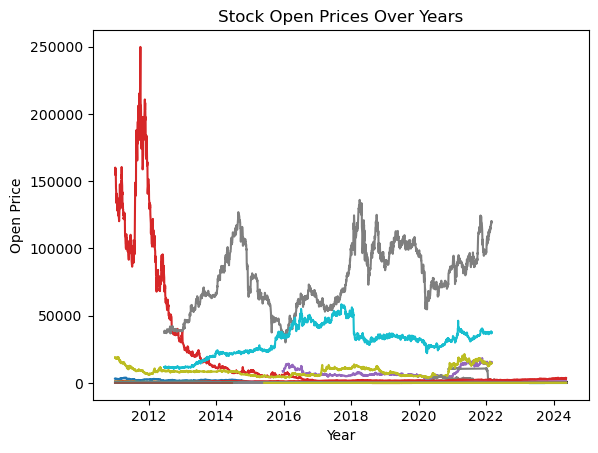

In [29]:
import matplotlib.pyplot as plt

for ticker in list(cleaned_historical_datas.keys()):
    plt.plot(cleaned_historical_datas[ticker]['open'])

# Add labels to the axes
plt.xlabel('Year')
plt.ylabel('Open Price')

# Add a title to the plot
plt.title('Stock Open Prices Over Years')

# Show the plot
plt.show()

Not really helpful, but what on earth is that red line that was trading at 250k in 2012?

In [30]:
max_name = ''
max_price = 0

for ticker in cleaned_historical_datas:
    ticker_max = cleaned_historical_datas[ticker]['open'].max()
    if ticker_max >= max_price:
        max_name = ticker
        max_price = ticker_max

print(f'max stock: {max_name} trading at {max_price}')

max stock: VIXY trading at 249840.0


Looks like it was VIXY (ProShares VIX Short-Term Futures ETF), a fund usually used to hedge against market downturns. 

Lets identify the top performing stocks and graph them over time

In [31]:

stock_rates_of_change = {}

for ticker, ticker_df in cleaned_historical_datas.items():
    init_price = ticker_df['open'].iloc[0]
    if init_price > 0:
        final_price = ticker_df['open'].iloc[-1]
        rate_of_change = (final_price - init_price) / init_price * 100
    else:
        rate_of_change = 0
    stock_rates_of_change[ticker] = rate_of_change
        

#Store top performers
top_stock_performers = sorted(stock_rates_of_change.items(), key=lambda x: x[1], reverse=True)

Lets graph the top 10 performers

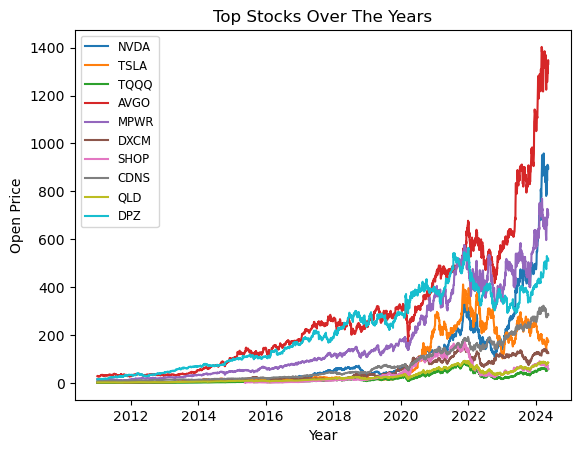

In [32]:
for ticker in top_stock_performers[:10]:
    plt.plot(cleaned_historical_datas[ticker[0]]['open'], label=ticker[0])

plt.xlabel('Year')
plt.ylabel('Open Price')

# Add a title to the plot
plt.title('Top Stocks Over The Years')
plt.legend(fontsize='small')  
# Show the plot
plt.show()

Before we see how the senator's trades performed, lets see the break down of the stock's sectos


In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [33]:
import yfinance as yf

# sbux = yf.Ticker("GPRO")
# tlry = yf.Ticker("TLRY")

# 
# print(tlry.info['sector'])

industry_info = {}
for ticker in cleaned_historical_datas.keys():
    try:
        stock_ticker = yf.Ticker(ticker)
        stock_industry = stock_ticker.info['sector']
        if stock_industry in industry_info:
            industry_info[stock_industry] += 1
        else:
            industry_info[stock_industry] = 1
    except:
        print('no ticker found')
        # pass
            

        

no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticker found
no ticke

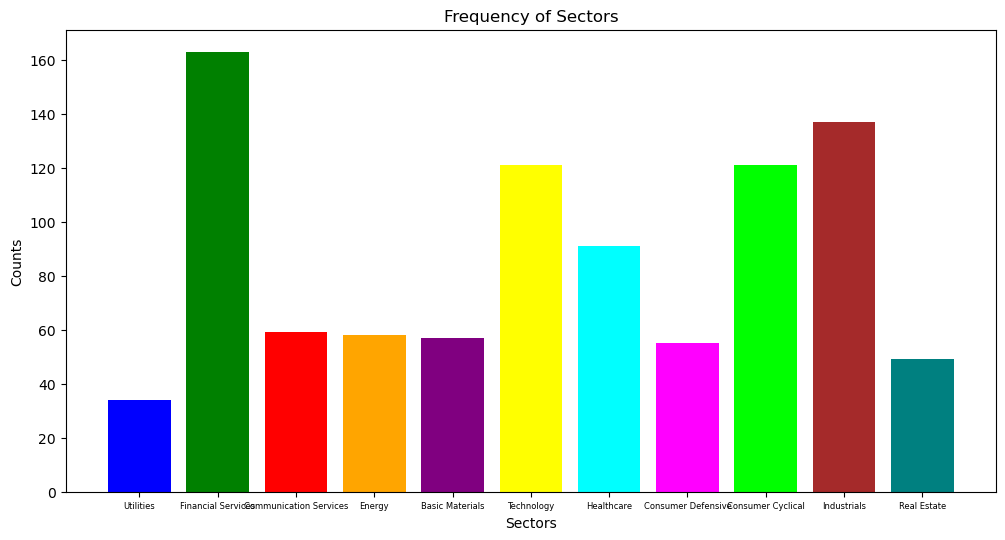

In [58]:
sectors = list(industry_info.keys())
counts = list(industry_info.values())
plt.figure(figsize=(12, 6))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'brown', 'teal']

plt.bar(sectors, counts, color=colors)

plt.xlabel('Sectors')
plt.ylabel('Counts')
plt.title('Frequency of Sectors')
plt.xticks(fontsize=6)  # Adjust font size here

# Displaying the plot
plt.show()

Looks like, Financial Services, Industrials, and Tech are the top sectors. Lets see a pie chart breakdown of the data.

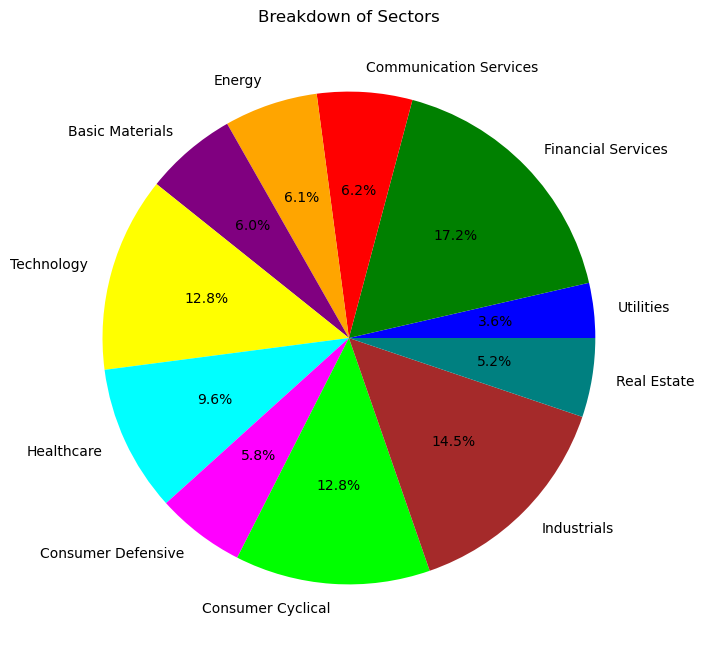

In [60]:
plt.figure(figsize=(8, 8))

# Creating the pie chart
plt.pie(counts, labels=sectors, autopct='%1.1f%%', colors=colors)

# Adding title
plt.title('Breakdown of Sectors')

# Displaying the plot
plt.show()

## Insert Comment about famous senators who are also business tycoons to explain investments

### Senator Performence
Now that we've seen a breakdown of the stocks the senators selected. Lets see how well each senator performed

In [113]:
senator_name_list = senator_filing_data_df['Senator Name'].unique()
counter = 0

senator_stock_returns = {}


for senator in senator_name_list:
    #for each stock owned, pull transactions related to stock and sort in order of date
    senator_transactions = senator_filing_data_df[senator_filing_data_df['Senator Name'] == senator].sort_values(by='Transaction Date', ascending=True)

    senator_returns_list = []
    
    for stock in senator_transactions['Ticker'].unique():
        stock_data = cleaned_historical_datas[stock]
        total_shares = 0
        realized_gains = 0
        unrealized_gains = 0
        curr_stock_price = stock_data.iloc[-1]['open']
        cost = 0
        data_available = True

        stock_transactions = senator_transactions[senator_transactions['Ticker'] == stock]
        for index, transaction in stock_transactions.iterrows():
            action = transaction['Transaction Type']
            amount = transaction['Amount']
            date = transaction['Transaction Date']
            
            #Its possible the transaction date had NAN values and was dropped
            #We can find the closest date in the table to the given date, but its better to just skip
            if date in stock_data.index:
                share_price_at_trans_date = stock_data.loc[date, 'open']
            else:
                #uncomment to use closest existing date in table
                # date_diff = abs(stock_data.index - date)

                # # Find the index label (date) with the minimum absolute difference
                # closest_date = date_diff.argmin()
                # share_price_at_trans_date = stock_data.iloc[closest_date]['open']
                data_available = False
                break

            num_shares_transacted = (amount / share_price_at_trans_date)

            #if senator is purchasing, total_shares is increments
            #and realized_profit is decremented. If senatro is selling (partial or full),
            #total_shares are decremented or limited to 0 if sale makes total shares negative
            #This can happen if senator owned shares before being in office, and they are not accounted
            #for by our data. 


            if (action == 'Purchase'):
                total_shares += num_shares_transacted
                cost += amount
            else:
                if total_shares > 0:
                    total_shares = max(0, total_shares - num_shares_transacted)
                    realized_gains += amount
                else:
                    #in this case they are selling shares that 
                    #were acquired before being in office
                    #In this case, the realized return is 
                    #the amount
                    realized_gains += amount
        #After all transactions are accounted for, we calculate any unrealized
        #gains with shares leftover. We use the price increase from the first reported price
        # to today
        if data_available:
            realized_gains = realized_gains - cost
            #realized gains are subtracted from cost as they reduce the cost basis
            unrealized_gains = (curr_stock_price * total_shares) - (cost - realized_gains)
            trade_data = {'Ticker': stock, 'realized_returns': realized_gains,
                          'unrealized_returns': unrealized_gains, 'total_returns': realized_gains + unrealized_gains}      
            senator_returns_list.append(trade_data)

     #if no data is available, do nothing       
    if senator_returns_list:
        senator_returns_df = pd.DataFrame(senator_returns_list)
        senator_stock_returns[senator] = senator_returns_df
    



In [114]:
ranked_senator_returns = {}

for senator in senator_stock_returns:
    ranked_senator_returns[senator] = senator_stock_returns[senator]['total_returns'].sum()

sorted(ranked_senator_returns.items(), key=lambda x: x[1], reverse=True)[:10]
    

[('Hagerty, Bill', 10159539.997878281),
 ('Scott, Rick', 4245906.278602254),
 ('Smith, Tina', 3547645.747024471),
 ('Whitehouse, Sheldon', 2325260.015099864),
 ('Perdue Jr, David A', 1927071.855068804),
 ('Hickenlooper, John', 1287258.324317931),
 ('Shaheen, Jeanne', 828953.0),
 ('King, Angus', 483095.21886924136),
 ('Cassidy, Bill', 455614.4191253986),
 ('Flake, Jeffry L', 391834.94158487715)]

The returns are likely off by several hundreds of thousands, but that can be attributed to the assumptions made about 
trade size, preowned shares, and dropped values in the tables. Despite this, the ordering of this list, should still be somewhat accurate.
It would be difficult to find exact numbers, however the top 10 list here agrees somewhat with this list provided by [investopedia](https://www.investopedia.com/articles/investing/041516/who-are-americas-7richest-senators.asp)

Lets do the calculations one more time, but this time excluding any transactions involving stocks that were acquired before filing.

In [119]:
senator_name_list = senator_filing_data_df['Senator Name'].unique()
counter = 0

in_office_senator_stock_returns = {}


for senator in senator_name_list:
    #for each stock owned, pull transactions related to stock and sort in order of date
    senator_transactions = senator_filing_data_df[senator_filing_data_df['Senator Name'] == senator].sort_values(by='Transaction Date', ascending=True)

    senator_returns_list = []
    
    for stock in senator_transactions['Ticker'].unique():
        stock_data = cleaned_historical_datas[stock]
        total_shares = 0
        realized_gains = 0
        unrealized_gains = 0
        curr_stock_price = stock_data.iloc[-1]['open']
        cost = 0
        data_available = True

        stock_transactions = senator_transactions[senator_transactions['Ticker'] == stock]
        for index, transaction in stock_transactions.iterrows():
            action = transaction['Transaction Type']
            amount = transaction['Amount']
            date = transaction['Transaction Date']
            
            #Its possible the transaction date had NAN values and was dropped
            #We can find the closest date in the table to the given date, but its better to just skip
            if date in stock_data.index:
                share_price_at_trans_date = stock_data.loc[date, 'open']
            else:
                #uncomment to use closest existing date in table
                # date_diff = abs(stock_data.index - date)

                # # Find the index label (date) with the minimum absolute difference
                # closest_date = date_diff.argmin()
                # share_price_at_trans_date = stock_data.iloc[closest_date]['open']
                data_available = False
                break

            num_shares_transacted = (amount / share_price_at_trans_date)

            #if senator is purchasing, total_shares is increments
            #and realized_profit is decremented. If senatro is selling (partial or full),
            #total_shares are decremented or limited to 0 if sale makes total shares negative
            #This can happen if senator owned shares before being in office, and they are not accounted
            #for by our data. 

            if (action == 'Purchase'):
                total_shares += num_shares_transacted
                realized_gains -= amount
            else:
                #only compute sale if there are shares available
                if total_shares > 0:
                    total_shares = max(0, total_shares - num_shares_transacted)
                    realized_gains += amount
 
        #After all transactions are accounted for, we calculate any unrealized
        #gains with shares leftover. We use the price increase from the first reported price
        # to today

        if data_available:
            realized_gains = realized_gains - cost
            #realized gains are subtracted from cost as they reduce the cost basis
            unrealized_gains = (curr_stock_price * total_shares) - (cost - realized_gains)
            trade_data = {'Ticker': stock, 'realized_returns': realized_gains,
                          'unrealized_returns': unrealized_gains, 'total_returns': realized_gains + unrealized_gains}      
            senator_returns_list.append(trade_data)


    if (senator_returns_list):
        senator_returns_df = pd.DataFrame(senator_returns_list)
        in_office_senator_stock_returns[senator] = senator_returns_df
    

In [120]:
in_office_ranked_senator_returns = {}

for senator in in_office_senator_stock_returns:
    in_office_ranked_senator_returns[senator] = in_office_senator_stock_returns[senator]['total_returns'].sum()

top_10_in_office_senators = sorted(in_office_ranked_senator_returns.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_in_office_senators

[('Scott, Rick', 8016972.278602254),
 ('Warner, Mark', 6458592.406451105),
 ('Wyden, Ron', 5559363.8864063155),
 ('Perdue Jr, David A', 4129230.8550688038),
 ('Whitehouse, Sheldon', 2085664.0150998642),
 ('Roberts, Pat', 1696191.2433072403),
 ('Daines, Steve', 1611150.417122487),
 ('McCaskill, Claire', 1218727.283990323),
 ('Portman, Robert J', 1180757.497605939),
 ('Warren, Elizabeth', 976069.7148818821)]

Lets see what this wealth distribution looks like

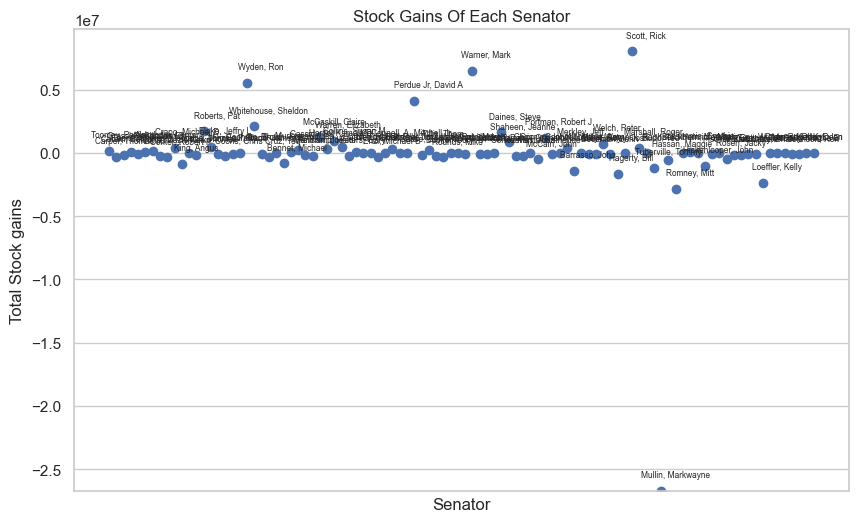

In [121]:
senators = [entry[0] for entry in in_office_ranked_senator_returns.items()]
total_gains = [entry[1] for entry in in_office_ranked_senator_returns.items()]
worst_gains = sorted(in_office_ranked_senator_returns.items(), key=lambda x: x[1], reverse=True)[-1]
# Set figure size (width, height) in inches
plt.figure(figsize=(10, 6))

# Creating the scatter plot
plt.scatter(senators, total_gains)
plt.ylim(worst_gains[1])

# Adding labels and title
plt.xlabel('Senator')
plt.ylabel('Total Stock gains')
plt.title('Stock Gains Of Each Senator')

# Rotating x-axis labels for better visibility
plt.xticks([])
for i, senator in enumerate(senators):
    plt.annotate(senator, (senators[i], total_gains[i]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=6)



# Displaying the plot
plt.show()


Lets get a better view of the top 10

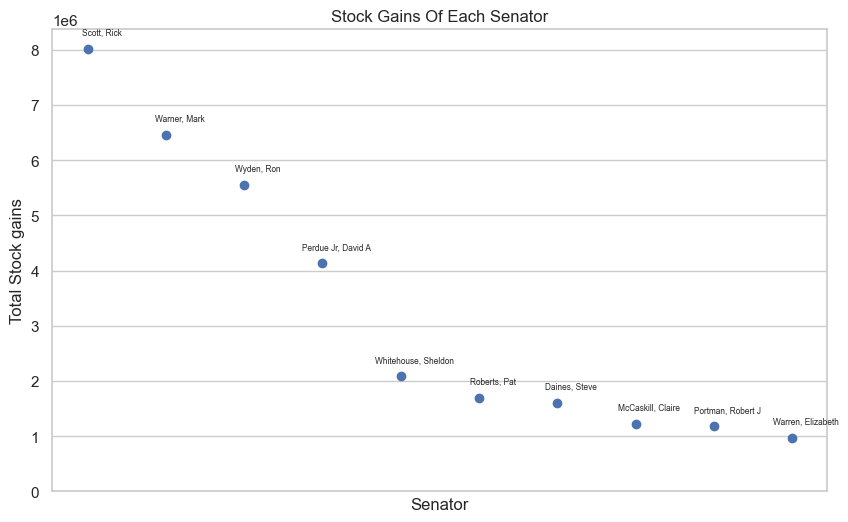

In [122]:
senators = [entry[0] for entry in top_10_in_office_senators]
total_gains = [entry[1] for entry in top_10_in_office_senators]
# Set figure size (width, height) in inches
plt.figure(figsize=(10, 6))

# Creating the scatter plot
plt.scatter(senators, total_gains)
plt.ylim(0)

# Adding labels and title
plt.xlabel('Senator')
plt.ylabel('Total Stock gains')
plt.title('Stock Gains Of Each Senator')

# Rotating x-axis labels for better visibility
plt.xticks([])
for i, senator in enumerate(senators):
    plt.annotate(senator, (senators[i], total_gains[i]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=6)



# Displaying the plot
plt.show()

Finally, lets make a box and whiskers plot to visualize the distribution of wealth. Lets use Seaborn for this

<Axes: xlabel='Total Returns'>

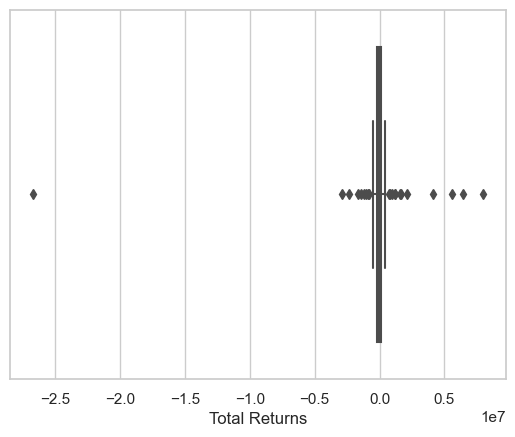

In [123]:
import seaborn as sns

sns.set(style='whitegrid')
senator_returns_df = pd.DataFrame(list(in_office_ranked_senator_returns.items()), columns=['Senator', 'Total Returns'])
sns.boxplot(x=senator_returns_df['Total Returns'])

I looks like a majority of the senators profited very little while in office compared to the outliers (Members of the top 10 senators).